<a href="https://colab.research.google.com/github/parham-nasiri/gpu_prediction/blob/main/gpu_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
import pandas as pd
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

In [204]:
from google.colab import files
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/gpu_data.txt'

#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
with open(file_path, "r") as f:
#with open("gpu_data.txt", "r") as f:
  data = json.load(f)

In [206]:
gpu_data = {}
for item in data["data"]["result"]:
    gpu_name = item["metric"]["gpu"]
    values = item["values"]

    for timestamp, value in values:
        if timestamp not in gpu_data:
            gpu_data[timestamp] = {}
        gpu_data[timestamp][gpu_name] = float(value)


sorted_times = sorted(gpu_data.keys())
all_gpus = sorted({gpu for t in gpu_data.values()for gpu in t.keys()})

final_vectors = []

for t in sorted_times:
    vector = [gpu_data[t].get(gpu, 0) for gpu in all_gpus]
    final_vectors.append(vector)

tensor_data = torch.tensor(final_vectors, dtype=torch.float32)

In [207]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(tensor_data)
scaled_data = torch.tensor(scaled_data, dtype=torch.float32)

In [208]:
def create_sequence(data,seq_lenght):
  X,y = [] ,[]
  for i in range(len(data)-seq_lenght):
    X.append(data[i:i+seq_lenght])
    y.append(data[i+seq_lenght])
  return torch.stack(X),torch.stack(y)
seq_lenght = 20
X,y = create_sequence(scaled_data,seq_lenght)

In [209]:
train_size = int(0.8*len(X))
X_train= X[:train_size]
y_train= y[:train_size]
X_test= X[:train_size]
y_test= y[:train_size]


In [210]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

/tmp/ipython-input-1211342857.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipython-input-1211342857.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


In [211]:
class GPUDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [212]:
batch_size = 32

train_loader = DataLoader(GPUDataset(X_train, y_train),
                          batch_size=batch_size,
                          shuffle=False)

test_loader = DataLoader(GPUDataset(X_test, y_test),
                         batch_size=batch_size,
                         shuffle=False)

In [213]:
class LSTMModel(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_size,dropout):
    super().__init__()
    self.lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout
    )
    self.fc = nn.Linear(hidden_size,num_size)
  def forward(self,X):
    out, _ = self.lstm(X)
    out = out[:, -1, :]
    out = self.fc(out)
    return out

In [214]:
device = torch.device("cuda" if torch.cuda.is_available()else "cpu")
model = LSTMModel(input_size= tensor_data.shape[1],hidden_size= 64,num_size=tensor_data.shape[1],num_layers= 2,dropout= 0.2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [215]:
print(X_train.shape)
print(y_train.shape)

torch.Size([6895, 20, 8])
torch.Size([6895, 8])


In [216]:
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}")

Epoch 0, Train Loss: 0.058343
Epoch 5, Train Loss: 0.020940
Epoch 10, Train Loss: 0.011328
Epoch 15, Train Loss: 0.006194
Epoch 20, Train Loss: 0.003653
Epoch 25, Train Loss: 0.003183
Epoch 30, Train Loss: 0.002956
Epoch 35, Train Loss: 0.002787
Epoch 40, Train Loss: 0.002729
Epoch 45, Train Loss: 0.002790


In [217]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        output = model(X_batch)

        all_preds.append(output.cpu())
        all_targets.append(y_batch.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

threshold = 0.05


approx_acc = ((abs(all_preds - all_targets) <= threshold).float().mean()) * 100
print(f"Approx Accuracy on test set: {approx_acc:.2f}%")

Approx Accuracy on test set: 87.20%


In [218]:
mae = (abs(all_preds - all_targets)).mean()
print(f"MAE: {mae:.4f}")

MAE: 0.0267


In [219]:
from sklearn.metrics import r2_score

r2 = r2_score(all_targets.cpu().numpy(), all_preds.cpu().numpy())
print(f"R²: {r2:.4f}")

R²: 0.6805


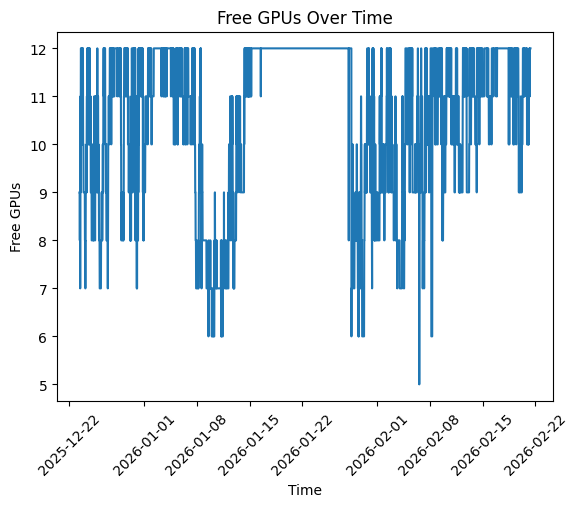

In [225]:
import pandas as pd
import matplotlib.pyplot as plt

gpu_data = data["data"]["result"][0]["values"]

timestamps = [int(item[0]) for item in gpu_data]
free_counts = [int(item[1]) for item in gpu_data]

df = pd.DataFrame({
    "timestamp": pd.to_datetime(timestamps, unit="s"),
    "free_gpus": free_counts
})

plt.figure()
plt.plot(df["timestamp"], df["free_gpus"])
plt.xlabel("Time")
plt.ylabel("Free GPUs")
plt.title("Free GPUs Over Time")
plt.xticks(rotation=45)
plt.show()

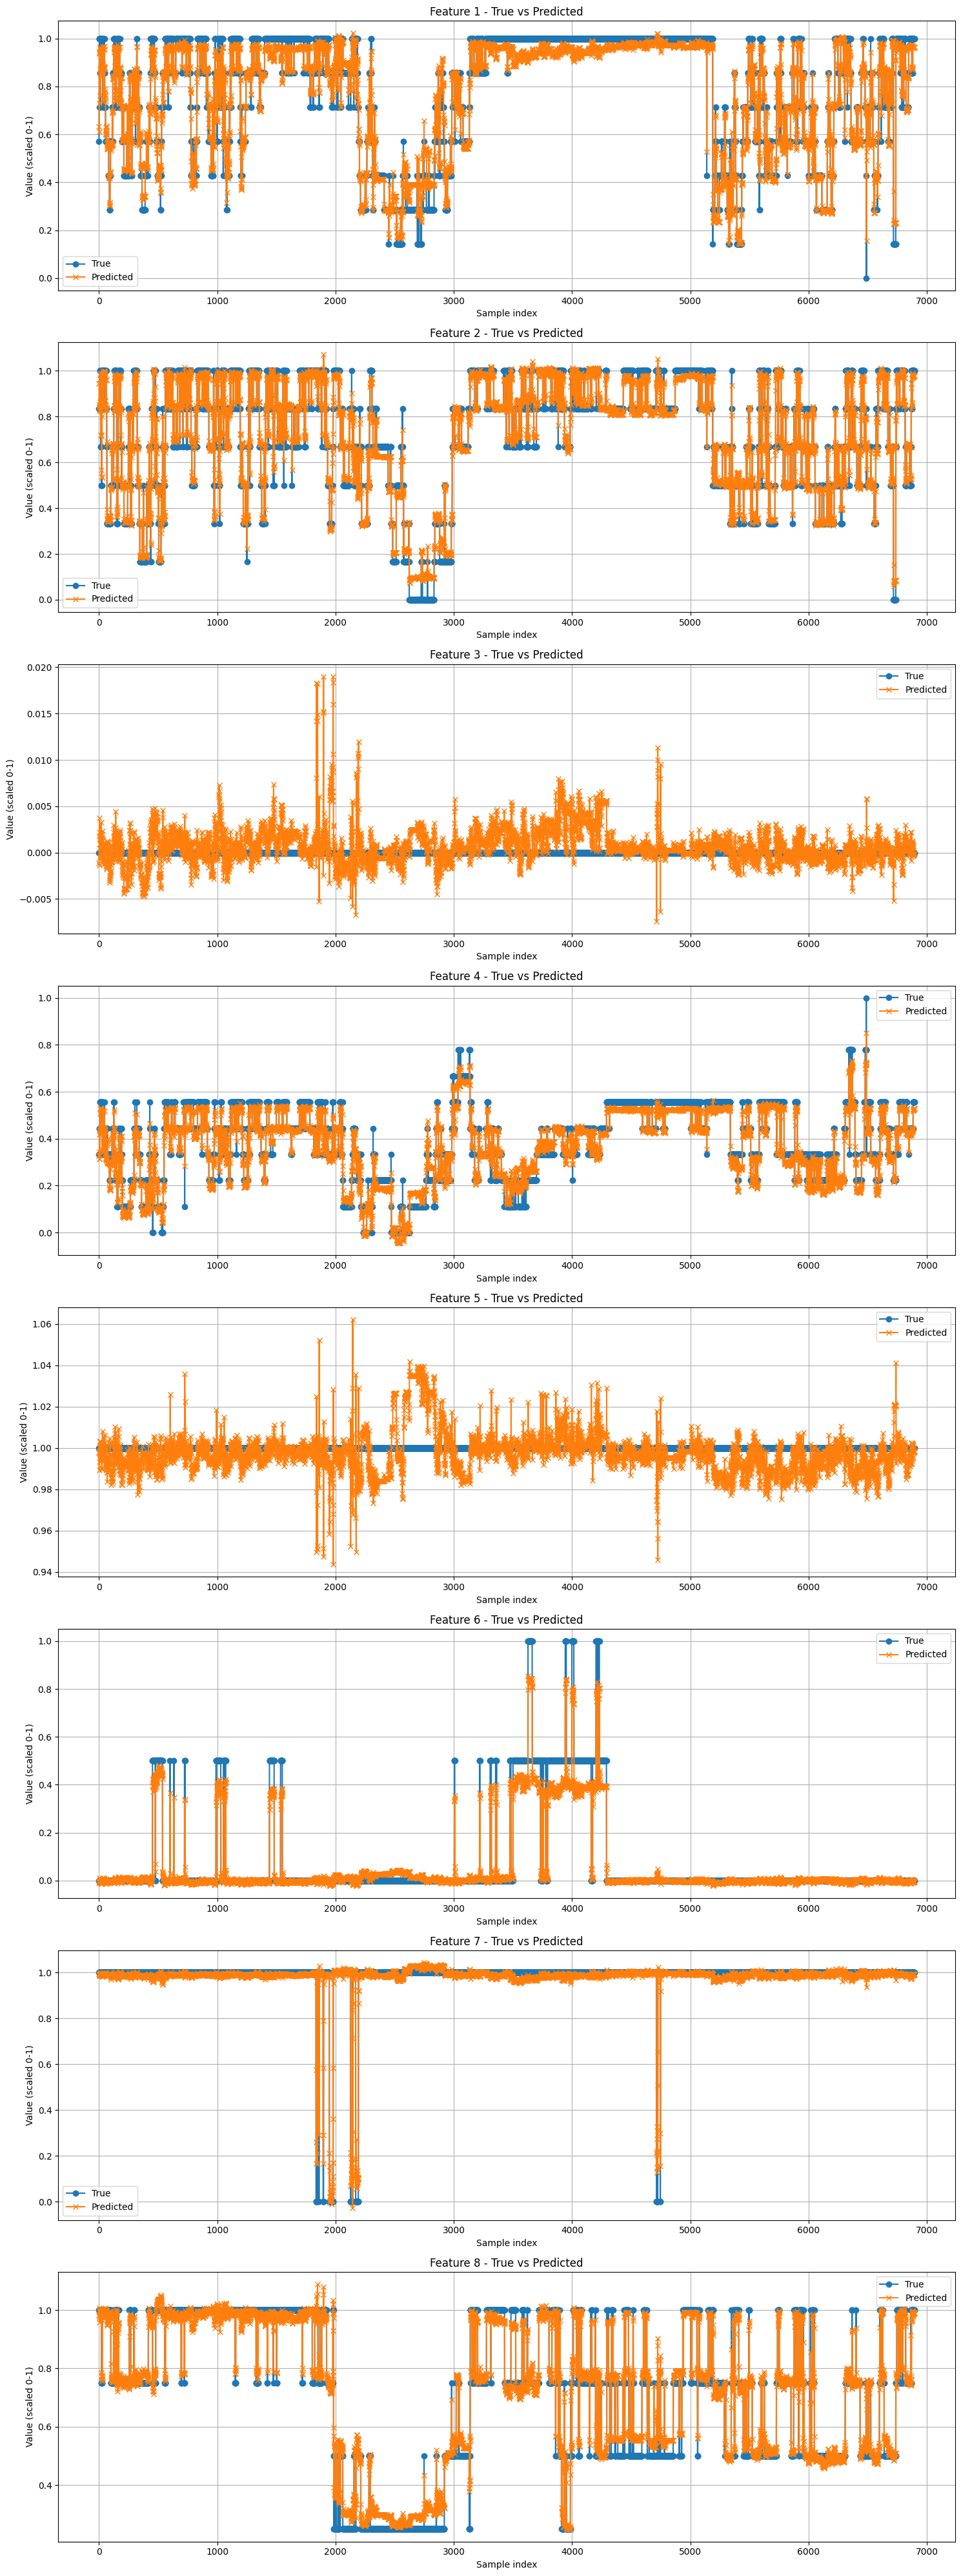

In [227]:
import matplotlib.pyplot as plt
import torch


num_features = all_targets.shape[1]

plt.figure(figsize=(15, 5*num_features))

for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.plot(all_targets[:, i], label="True", marker='o')
    plt.plot(all_preds[:, i], label="Predicted", marker='x')
    plt.title(f"Feature {i+1} - True vs Predicted")
    plt.xlabel("Sample index")
    plt.ylabel("Value (scaled 0-1)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [226]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_test_class = (y_test.cpu().numpy() >= threshold).astype(int)

model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        y_pred.append(output.cpu())
    y_pred = torch.cat(y_pred, dim=0).numpy()
    y_pred_class = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test_class.flatten(), y_pred_class.flatten())
acc = accuracy_score(y_test_class.flatten(), y_pred_class.flatten())

print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {acc*100:.2f}%")

Confusion Matrix:
[[12966   339]
 [   31 41824]]
Accuracy: 99.33%
